# TVC Site Selector

Statistical approach to site selection based on previous TVC obs.
Takes input of processed rasters at a 25 m resolutoin that 
represent snow depth, veg height, slope, and elevation. We do a bit
of pre-processing to remove areas with tall veg and steep slopes. 
Sites are then selected randomly based on an inversion of the cumulative
density function. A seed needs to be set if you want to have the same set
of random sites show up on sequential runs.

In [38]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
print(gpd.pd.__version__)

0.23.4


In [50]:
siksik_data = gpd.read_file('./data/shapefiles/geodata.shp')
siksik_data = siksik_data.dropna() 
siksik_shp = gpd.read_file('./data/shapefiles/siksik.shp')
siksik_geoms = siksik_shp.iloc[0].geometry
siksik_sub = siksik_data[siksik_data.geometry.within(siksik_geoms)]

veg_max = 0.5 # Max veg height in m we're willing to deal with
slope_max = 15 # Max slope in deg we're willing to deal with
snow_min = 0.05 # Helps avoid lakes

siksik_sub = siksik_sub[siksik_sub['vegheight_']<= veg_max]
siksik_sub = siksik_sub[siksik_sub['slope_valu']<= slope_max]

Establish bin size for the initial density function

In [51]:
snow_max = np.round(siksik_sub.snow_depth.max()+0.5)
snow_min = 0.1
snow_step = 0.01 #Bin width of 1 cm
bsnow = np.arange(snow_min,snow_max,snow_step) #These are the histogram bins

Here we calculate a probability density function (PDF), invert its cumulative density (CDF).
The bins are bound by the observations so we don't extrapolate.

In [52]:
hist, bin_edges = np.histogram(siksik_sub.snow_depth, bins=bsnow, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)

Text(0.5, 1.0, 'SikSik Snow depth CDF')

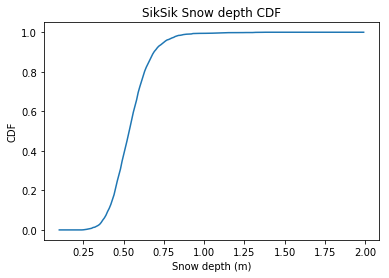

In [44]:
plt.plot(bin_edges, cum_values)
plt.xlabel("Snow depth (m)")
plt.ylabel("CDF")
plt.title('SikSik Snow depth CDF')

Example of how to pull random samples from the distrobution
1. Select number of samples (N)
2. Generate N random numbers between 0-1
3. Use the inverted cdf to pull samples from the known distrobution
4. Find nearest match in the obs. Need to do this because we interpolate the cdf.

If you pull enough samples, you'll recreate the observed distrobution.

In [45]:
n_samples = 50
r = np.random.rand(n_samples)
depth_sample = inv_cdf(r)
sample_records = [siksik_sub.iloc[(siksik_sub['snow_depth']-x).abs().argsort()[:1]] for x in depth_sample]

print(depth_sample[0])
print(sample_records[0].snow_depth)

0.40132949706798804
19048    0.401374
Name: snow_depth, dtype: float64


Subset the sampling sites

In [46]:
sample_idx = np.concatenate([x.index for x in sample_records]).ravel()
sites = siksik_sub.loc[sample_idx.astype(int)]

In [47]:
print('Sample Site Stats')
sample_stats = pd.concat([sites.mean(), sites.std(), sites.min(), sites.max()], axis=1, sort=False)
sample_stats.columns = ['Mean', 'StDev', 'Min', 'Max']
print(sample_stats)

Sample Site Stats
                 Mean      StDev        Min         Max
snow_depth   0.532443   0.120977   0.275252    0.818693
dem_value   97.003485  26.324585  50.529022  128.986374
slope_valu   2.681150   2.406200   0.442590   10.170991
vegheight_   0.241599   0.081081   0.132945    0.493811


In [48]:
print('Domain Reference Stats')
domain_stats = pd.concat([siksik_sub.mean(), siksik_sub.std(), siksik_sub.min(), siksik_sub.max()], axis=1, sort=False)
domain_stats.columns = ['Mean', 'StDev', 'Min', 'Max']
print(domain_stats)


Domain Reference Stats
                 Mean      StDev       Min         Max
snow_depth   0.543420   0.122052   0.00000    1.366317
dem_value   96.041769  24.904398  47.16917  131.024429
slope_valu   2.208846   1.637730   0.00000   11.880609
vegheight_   0.268124   0.084038   0.01617    0.498617


### Basic plot
Formatting of labels and colorbars can get messy, but this is a good way to get a plot or series of axes plotted
1. Setup the figure and axes (default 1 axis per figure)
2. Plot using the pandas/geopandas `.plot()` but being careful to say which axis it should go on

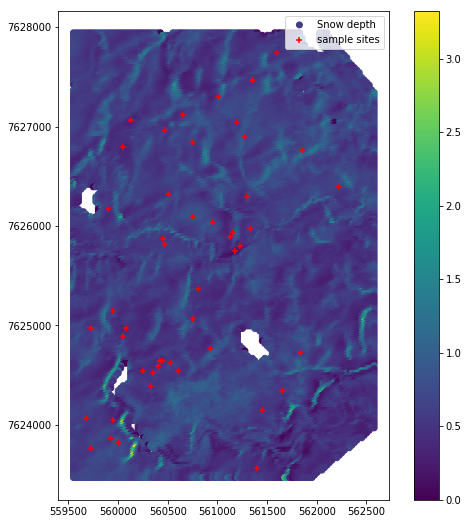

In [49]:
fig, ax = plt.subplots(figsize=(9,9))
siksik_data.plot(ax=ax, column='snow_depth', label='Snow depth', legend=True)
sites.plot(ax=ax, marker='+', color='red', markersize=30, label='sample sites', legend=True)
ax.legend(); # this just adds the label box within the axis

## Multi-axis plot

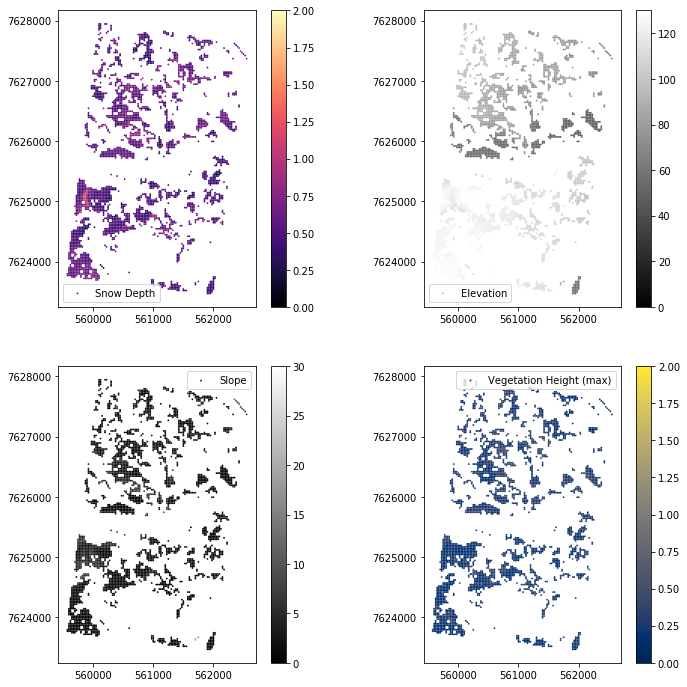

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
snow, dem, slope, veg = axes.ravel()
siksik_sub.plot(ax=snow, column='snow_depth', markersize=0.6, vmin=0, vmax=2, cmap='magma', label='Snow Depth', legend=True)
siksik_sub.plot(ax=dem, column='dem_value', markersize=0.6, vmin=0, vmax=130, cmap='gray', label='Elevation', legend=True)
siksik_sub.plot(ax=slope, column='slope_valu', markersize=0.6, vmin=0, vmax=30, cmap='gray', label='Slope', legend=True)
siksik_sub.plot(ax=veg, column='vegheight_', markersize=0.6, vmin=0, vmax=2, cmap='cividis', label='Vegetation Height (max)', legend=True)
snow.legend()
dem.legend()
slope.legend()
veg.legend();